<a href="https://colab.research.google.com/github/jurados/NotesPytorch/blob/main/%5B02%5D_PyTorch_Workflow_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural
                     # networks

from tqdm.auto import tqdm

# Check PyTorch version
torch.__version__

'2.3.1+cu121'

# Data (preparing and loading)

Machine Learning is a game of two parts:
1. Get data into a numerical representations.
2. Build a model to learn patterns in that numerical representations.

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

## Splitting data into training and test sets

In [4]:
# Create a train/test split

train_split = int(0.8*len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
X_train, y_train

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260],
         [0.4400],
         [0.4540],
         [

In [6]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(fontsize=14)

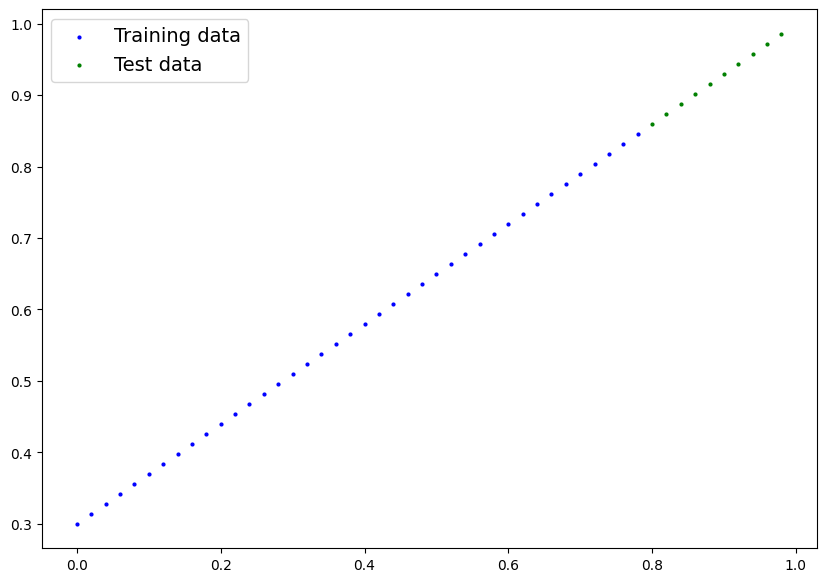

In [7]:
plot_predictions()

## Build Model

What our model does:

- Start with random values (weight and bias)
- Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight and bias values we used to created the data)

How does it do so?

Through two main algorithms:

1. Gradient descent
2. Backpropragation

### Linear regression model from scratch

The weights and biases (`w11`,`w12`,$\cdots$ `w23`, `b1` and `b2`) can also be represented as matrices, initialized as random values.

In [8]:
# Create a linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via grandient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1, # <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via grandient descent?
                                            dtype=torch.float)) # <- PyTorch loves the datatype torch.float32

  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias # this is the linear regression formula


## PyTorch model building essentials

- `torch.nn` - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
- `torch.nn.Parameter` - what parameters should our model try and learn, often a PyTorch layer from `torch.nn` will set these for us.
- `torch.nn.Module` - the base class for all neural network modules, if you subclass it, you should overwrite forward()
- `torch.optim` - this where the optimizers in PyTorch live, they will help with gradient descent.
- `def forward()` - All `nn.Module` subclasesses require you to overwrite `forward()`, this method defines what happens in the forward computation.

## Checking the contents of our PyTorch model

We can check our model parameters or what's inside our model using `.parameters()`.

In [9]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [10]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

## Making prediction using `torch.inference_mode()`

To check our model's predictive power, let's see how well it predict `y_test` based on `X_test`.

When we pass data through our model, it's going to run it through the `forward()` method.

In [11]:
# Make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do something similar with torch.no_grad(),
# however, torch.inference_mode() is preferred
#with torch.no_grad():
#  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

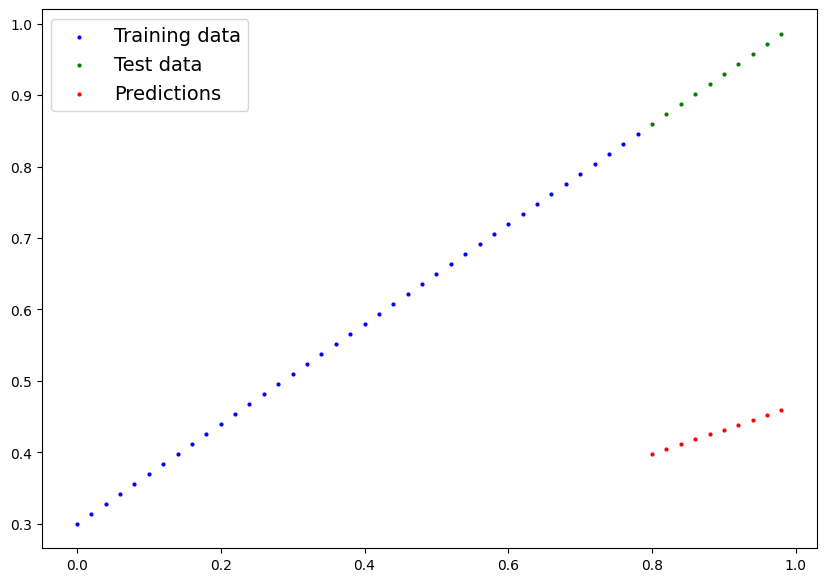

In [13]:
plot_predictions(predictions=y_preds)

## Train Model

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note: Loss function may also be called cost function or criterion in  different areas.

* **Loss Function:** A function to measure how wrong your model's prediction are to the ideal outputs, lower is better. We can compare the model's predictions with the actual targets, using the following method:
  - Calculate the difference between the two matrices(`preds` and `targets`).
  - Square all elements of the difference matrix to remove negative values.
  - Calculate the average of the elements in the resulting matrix.

The result is a single number, known as the **Mean Squared Error** (MSE).

$$\text{MSE} = \frac{1}{N} \sum_{i=1}^{n} \left(y_i - \hat{y}_i\right)^{2}$$

* **Optimizer:** Takes into account the loss function of a model and adjust the model's parameters (e.g. weight and bias) to improve the loss function.

And specifically for PyTorch, we need:

- A training loop
- A testing loop

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [15]:
# Check out our model's parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [16]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

## Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:

1. Loop through the data.
2. Forward pass (this involves data moving through our model's `forward()` functions) to make predictions on data - also called forward propagation.
3. Calculate the loss (compare forward pass predictions to ground truth labels).
4. Optimizer zero grad.
5. Loss backward - move backwards through the network to calculate the gradients of each the parameters of our model with respects to the loss.
6. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss.

In [17]:
torch.manual_seed(42)

# An epoch is one loop through the data ...
epochs = 100

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in PyTorch sets all parameters that requieres gradients to requiered gradients

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perfrom backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so ... we have to zero them above in
                   # step 3 for the next iteration of the loop.

  ### Testing
  model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking and a couple more things behind the scenes
    # 1. Do the forward pass
    test_pred = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

    # Print out model state_dict()
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

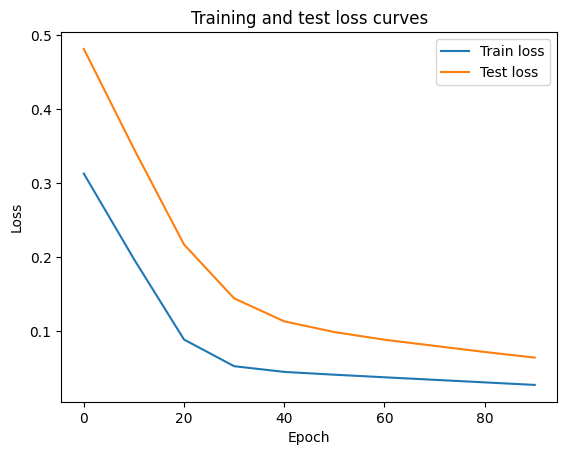

In [18]:
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label='Train loss')
plt.plot(epoch_count, test_loss_values, label='Test loss')
plt.title('Training and test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [20]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [21]:
weight, bias

(0.7, 0.3)

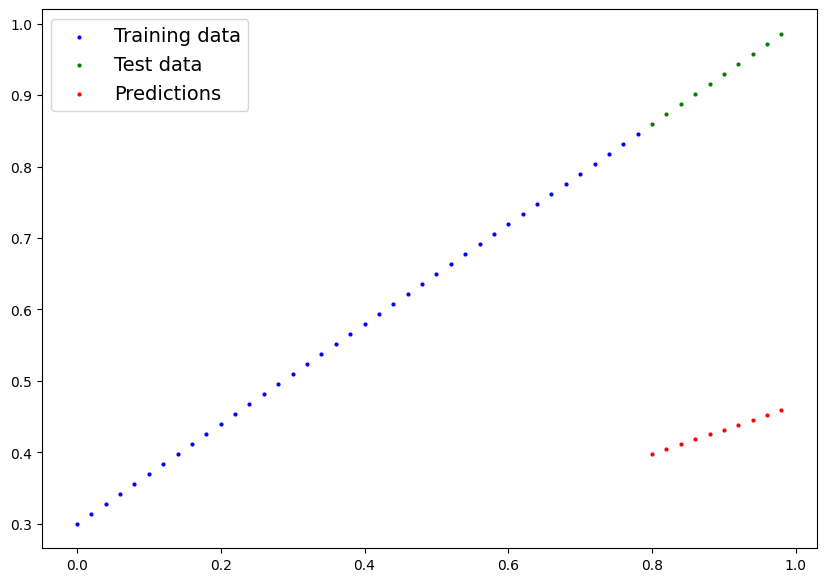

In [22]:
plot_predictions(predictions=y_preds)

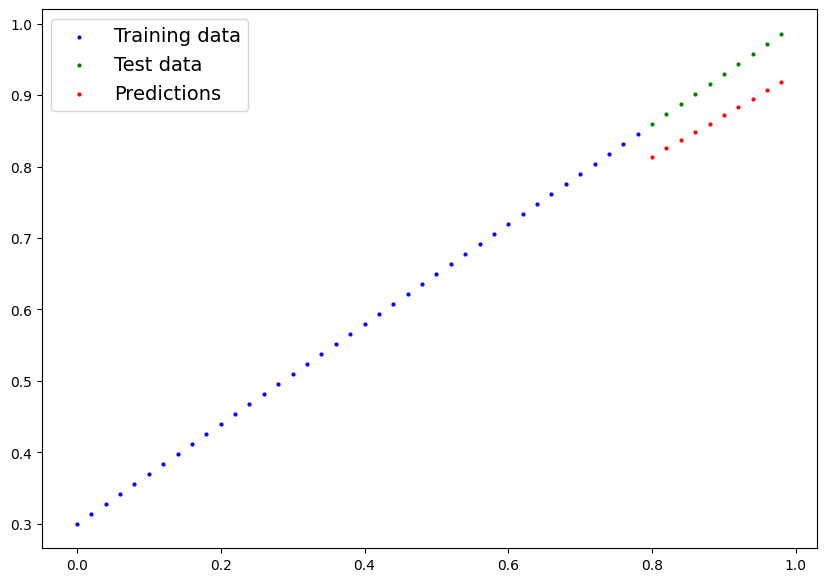

In [23]:
plot_predictions(predictions=y_preds_new)

## Saving a model in PyTorch

There are three main methods you should about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format.
2. `torch.load()` - allows you load a saved PyTorch objedt.
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [24]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_0.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [26]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [27]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [28]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

In [29]:
# Compared loaded model preds with original model preds
y_preds == loaded_model_preds

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])

# Example of a Linear Regression

|Region|Temp. (F)|Reinfall (mm)|Humidity (%)|Apples (ton)|Oranges (ton)|
|------|:------:|:------------:|:----------:|:----------:|:-----------:|
|Kanto |73      |67            |43          |56          |70           |  
|Johto |91      |88            |64          |81          |101          |  
|Hoenn |87      |134           |58          |119         |133          |  
|Sinnoh|102     |43            |37          |22          |37           |  
|Unova |69      |96            |70          |103         |119          |  

In [30]:
# Inputs (temp, rainfall, humidity)
inputs = np.array([[73,67,43],
                   [91,88,64],
                   [87,134,58],
                   [102,43,37],
                   [69,96,40]], dtype='float32')

# Targets (temp, rainfall, humidity)
targets = np.array([[56,70],
                   [81,101],
                   [119,133],
                   [22,37],
                   [103,119]], dtype='float32')

In [31]:
# Convert inputs and targets to tensors
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
inputs, targets

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.],
         [102.,  43.,  37.],
         [ 69.,  96.,  40.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.],
         [ 22.,  37.],
         [103., 119.]]))

In [32]:
# Weights and biases
W = torch.rand(2,3, requires_grad=True)
b = torch.rand(2,requires_grad=True)
print(f'Weights:\n{W}')
print(f"Biases:\n{b}")

Weights:
tensor([[0.3904, 0.6009, 0.2566],
        [0.7936, 0.9408, 0.1332]], requires_grad=True)
Biases:
tensor([0.9346, 0.5936], requires_grad=True)


We can define the model as follows:

In [33]:
model = lambda X: X @ W.t() + b

In [34]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 80.7299, 127.2881],
        [105.7648, 164.1267],
        [130.3048, 203.4285],
        [ 76.0920, 126.9260],
        [ 95.8244, 150.9963]], grad_fn=<AddBackward0>)

In [35]:
# Compare with targets
targets

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])

In [36]:
# MSE loss
def mse(t1,t2):
  diff = t1 - t2
  return torch.sum(diff*diff)/diff.numel()

In [37]:
loss = mse(preds, targets)
loss

tensor(2566.7642, grad_fn=<DivBackward0>)

## Compute gradients

In [38]:
# Compute gradients
loss.backward()

In [39]:
# Gradients for weights
print(W)
print(W.grad)

tensor([[0.3904, 0.6009, 0.2566],
        [0.7936, 0.9408, 0.1332]], requires_grad=True)
tensor([[2012.9327, 1397.6292, 1003.6783],
        [5486.8101, 5153.8691, 3039.0940]])


We reset the greadients to zero by calling `.zero_()` method. We need to do this, because PyTorch accumulates, gradient i.e. the next times we call `.backward` on the loss the new gradient vfalues will get added to the existing gradient values, which may lead to unexpected results.

In [40]:
W.grad.zero_()
b.grad.zero_()
W.grad, b.grad

(tensor([[0., 0., 0.],
         [0., 0., 0.]]),
 tensor([0., 0.]))

## Adjust weights and biases using gradient descent
We'll reduce the loss and improve our model using the gradient descent optimization algorithm, which has the following steps.

1. Generate predictions.
2. Calculate the loss.
3. Compute gradients, the weight and biases.
4. Adjust the weights by sustracting a small quantity proportional to the gradient.
5. Reset the gradients to zero.

In [41]:
# Generate predictions
preds = model(inputs)
preds

tensor([[ 80.7299, 127.2881],
        [105.7648, 164.1267],
        [130.3048, 203.4285],
        [ 76.0920, 126.9260],
        [ 95.8244, 150.9963]], grad_fn=<AddBackward0>)

In [42]:
# Calculate the loss
loss = mse(preds, targets)
loss

tensor(2566.7642, grad_fn=<DivBackward0>)

In [43]:
# Compute gradients
loss.backward()
W.grad, b.grad

(tensor([[2012.9327, 1397.6292, 1003.6783],
         [5486.8101, 5153.8691, 3039.0940]]),
 tensor([21.5432, 62.5531]))

Finally, we update the weights and biases using the gradietn computed above

In [44]:
# Ajust weights and reset gradients
with torch.inference_mode(): # We use this to indicate to PyTorch tath we shouldn't track, calculate or modify gradients while updating the weights and biases
  W -= W.grad * 1e-5 # We multiplly the gradietns with a really small number (1e-5), to ensure that we don't modify the weights by a really large mount
  b -= b.grad * 1e-5
  W.grad.zero_()
  b.grad.zero_()

In [45]:
W, b

(tensor([[0.3703, 0.5869, 0.2465],
         [0.7388, 0.8892, 0.1028]], requires_grad=True),
 tensor([0.9344, 0.5930], requires_grad=True))

In [46]:
# Calculate the loss
loss = mse(preds, targets)
loss

tensor(2566.7642, grad_fn=<DivBackward0>)

## Train for multiple epochs

In [48]:
# Train for 100 epochs:
for i in tqdm(range(100)):
  preds = model(inputs)
  loss = mse(preds, targets)
  loss.backward()

  with torch.no_grad():
    W -= W.grad * 1e-5
    b -= b.grad * 1e-5
    W.grad.zero_()
    b.grad.zero_()

  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
preds = model(inputs)
loss = mse(preds, targets)
loss

tensor(185.2309, grad_fn=<DivBackward0>)

# Putting in all Together

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## Data

In [51]:
# Create some data using the linear regression formula
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [52]:
# Split data
train_split = int(0.8*len(X_train))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

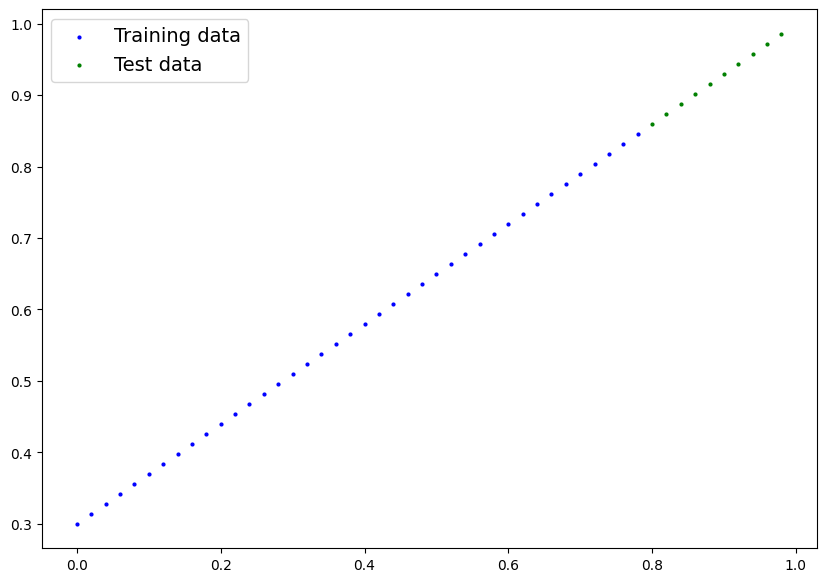

In [53]:
plot_predictions()

## Building a PyTorch model

In [54]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [55]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [56]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [57]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

## Training

In [58]:
# Setup loss function
loss_fn = nn.L1Loss()

# setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [59]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test  = X_test.to(device)
y_test  = y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred,y_test)

  # Print out what's happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.550014853477478 | Test loss: 0.5697731375694275
Epoch: 10 | Loss: 0.440405011177063 | Test loss: 0.444663405418396
Epoch: 20 | Loss: 0.33079516887664795 | Test loss: 0.3195537328720093
Epoch: 30 | Loss: 0.2211853414773941 | Test loss: 0.1944439560174942
Epoch: 40 | Loss: 0.11157549917697906 | Test loss: 0.0693342313170433
Epoch: 50 | Loss: 0.015460771508514881 | Test loss: 0.03690970689058304
Epoch: 60 | Loss: 0.012020175345242023 | Test loss: 0.03583583980798721
Epoch: 70 | Loss: 0.009691683575510979 | Test loss: 0.028384936973452568
Epoch: 80 | Loss: 0.007374221459031105 | Test loss: 0.021721038967370987
Epoch: 90 | Loss: 0.005051673389971256 | Test loss: 0.01427010353654623
Epoch: 100 | Loss: 0.0027588997036218643 | Test loss: 0.006839417852461338
Epoch: 110 | Loss: 0.00694500096142292 | Test loss: 0.0009425050811842084
Epoch: 120 | Loss: 0.00694500096142292 | Test loss: 0.0009425050811842084
Epoch: 130 | Loss: 0.00694500096142292 | Test loss: 0.000942505081184208

In [60]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6877]])),
             ('linear_layer.bias', tensor([0.2969]))])

## Making and evaluation predictions

In [61]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)

In [62]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')

  # plot test data in green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')

  # Are there predictions?
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label='Predictions')

  # Show the legend
  plt.legend(fontsize=14)

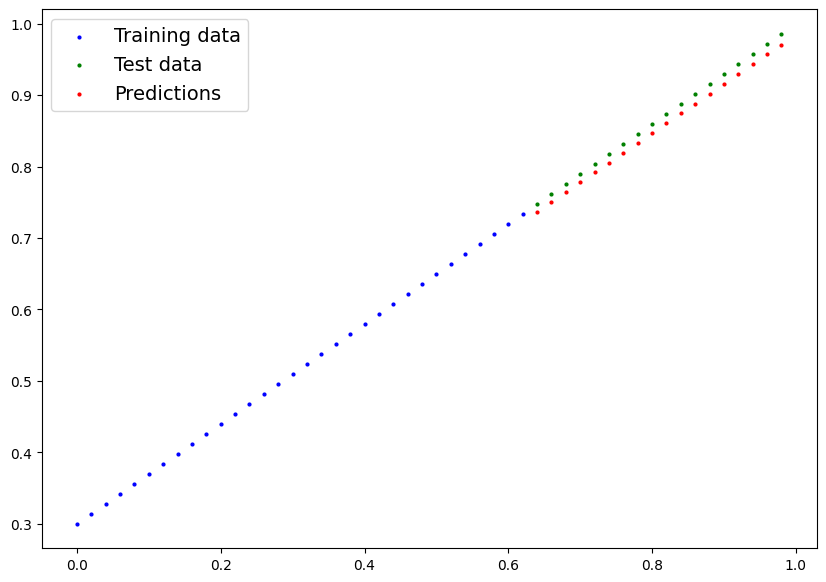

In [63]:
plot_predictions(predictions=y_preds)

## Saving and loading a trained model

In [64]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = '01_pytorch_workflow_model_1.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [65]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_1 = LinearRegressionModel()

# Load the saved state_dict of model_0
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

# Continue with Example of a Linear Regression using PyTorch Built-ins

|Region|Temp. (F)|Reinfall (mm)|Humidity (%)|Apples (ton)|Oranges (ton)|
|------|:------:|:------------:|:----------:|:----------:|:-----------:|
|Kanto |73      |67            |43          |56          |70           |  
|Johto |91      |88            |64          |81          |101          |  
|Hoenn |87      |134           |58          |119         |133          |  
|Sinnoh|102     |43            |37          |22          |37           |  
|Unova |69      |96            |70          |103         |119          |  

In [66]:
# Inputs (temp, rainfall, humidity)
inputs = np.array([[73,67,43],
                   [91,88,64],
                   [87,134,58],
                   [102,43,37],
                   [69,96,70],
                   [73,67,43],
                   [91,88,64],
                   [87,134,58],
                   [102,43,37],
                   [69,96,70],
                   [73,67,43],
                   [91,88,64],
                   [87,134,58],
                   [102,43,37],
                   [69,96,70]], dtype='float32')

# Targets (temp, rainfall, humidity)
targets = np.array([[56,70],
                   [81,101],
                   [119,133],
                   [22,37],
                   [103,119],
                    [81,101],
                   [119,133],
                   [22,37],
                   [103,119],
                    [56,70],
                    [81,101],
                   [119,133],
                   [22,37],
                   [103,119],
                    [22,37]], dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

## Dataset and DataLoader

We'll create a `TensorDataset`, which allows access to rows from `inputs` and `targets` as tuples, and provides standard APIs for working with many different types of datasets in PyTorch.

In [67]:
from torch.utils.data import TensorDataset

In [68]:
# Define dataset
train_dataset = TensorDataset(inputs, targets)
train_dataset[:3]

(tensor([[ 73.,  67.,  43.],
         [ 91.,  88.,  64.],
         [ 87., 134.,  58.]]),
 tensor([[ 56.,  70.],
         [ 81., 101.],
         [119., 133.]]))

We'll also create `DataLoader`, which can split the data into batches of a predefined size while training. It also provides other utilities like shuffling and random sampling of the data.

In [69]:
from torch.utils.data import DataLoader

In [70]:
# Define data lodaer
batch_size = 5
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [72]:
for X, y in train_dataloader:
  print(X)
  print(y)

tensor([[ 91.,  88.,  64.],
        [ 69.,  96.,  70.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 73.,  67.,  43.]])
tensor([[119., 133.],
        [103., 119.],
        [ 22.,  37.],
        [103., 119.],
        [ 81., 101.]])
tensor([[102.,  43.,  37.],
        [ 87., 134.,  58.],
        [ 73.,  67.,  43.],
        [102.,  43.,  37.],
        [ 91.,  88.,  64.]])
tensor([[103., 119.],
        [119., 133.],
        [ 81., 101.],
        [ 22.,  37.],
        [ 81., 101.]])
tensor([[ 73.,  67.,  43.],
        [ 87., 134.,  58.],
        [ 69.,  96.,  70.],
        [ 91.,  88.,  64.],
        [ 69.,  96.,  70.]])
tensor([[ 56.,  70.],
        [ 22.,  37.],
        [ 22.,  37.],
        [119., 133.],
        [ 56.,  70.]])


## `nn.Linear`

In [73]:
# Define model
model = nn.Linear(in_features=3, out_features=2)
print(f'weight model: {model.weight} and bias model: {model.bias}')

weight model: Parameter containing:
tensor([[ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853]], requires_grad=True) and bias model: Parameter containing:
tensor([-0.2695,  0.1472], requires_grad=True)


In [74]:
# Parameters
list(model.parameters()) # return a list containing all the weights and bias matrices present in the model

[Parameter containing:
 tensor([[ 0.4266,  0.0782,  0.2784],
         [-0.0815,  0.4451,  0.0853]], requires_grad=True),
 Parameter containing:
 tensor([-0.2695,  0.1472], requires_grad=True)]

In [76]:
# Generate predictions
y_preds = model(inputs)
y_preds

tensor([[48.0783, 27.6857],
        [63.2445, 37.3570],
        [63.4647, 57.6443],
        [56.9014, 14.1280],
        [56.1562, 43.2230],
        [48.0783, 27.6857],
        [63.2445, 37.3570],
        [63.4647, 57.6443],
        [56.9014, 14.1280],
        [56.1562, 43.2230],
        [48.0783, 27.6857],
        [63.2445, 37.3570],
        [63.4647, 57.6443],
        [56.9014, 14.1280],
        [56.1562, 43.2230]], grad_fn=<AddmmBackward0>)

## Loss function
Instead of defining a loss function manually, we can use the built-in loss function `mse_loss`

In [77]:
import torch.nn.functional as F

The `nn.functional` package contains many useful loss function and several other utilities.

In [78]:
# Define loss function
loss_fn = F.mse_loss

In [79]:
loss = loss_fn(model(inputs), targets)
loss

tensor(3151.6440, grad_fn=<MseLossBackward0>)

## Optimizer

In [80]:
# Define optimizer
opt = torch.optim.SGD(params=model.parameters(), lr =1e-5)

## Train the model

In [81]:
# Utility function to train the mode
def fit(num_epochs, model, loss_fn, opt, train_dataloader):

  # Repeat for given number of epochs
  for epoch in tqdm(range(num_epochs)):

    # Train with batches of data:
    for X_train, y_train in train_dataloader:

      # 1. Generate predictions
      pred = model(X_train)

      # 2. Calculate loss
      loss = loss_fn(pred, y_train)

      # 3. Compute gradients
      loss.backward()

      # 4. Update parameters using gradients
      opt.step()

      # 5. Reset the gradient to zero
      opt.zero_grad()

    if (epoch+1) %10 == 0:
      print(f"Epoch: {epoch+1} | Loss: {loss.item():.4f}")

Instead of updating parameters (weights and biases) manually, we use `opt.step()` to perfom the update, and `opt.zero_grad()` to reset the gradients to zero.

In [82]:
fit(num_epochs=100,model=model,loss_fn=loss_fn,opt=opt,train_dataloader=train_dataloader)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 | Loss: 2070.3545
Epoch: 20 | Loss: 1695.8510
Epoch: 30 | Loss: 1909.1770
Epoch: 40 | Loss: 1614.5919
Epoch: 50 | Loss: 1751.9125
Epoch: 60 | Loss: 1536.5295
Epoch: 70 | Loss: 1506.6576
Epoch: 80 | Loss: 811.1422
Epoch: 90 | Loss: 941.4933
Epoch: 100 | Loss: 1543.3667


In [84]:
# Generate predicitons
y_preds = model(inputs)
y_preds

tensor([[62.9515, 75.6394],
        [82.6672, 98.2071],
        [68.0843, 89.2702],
        [86.5788, 99.5543],
        [67.3625, 81.3375],
        [62.9515, 75.6394],
        [82.6672, 98.2071],
        [68.0843, 89.2702],
        [86.5788, 99.5543],
        [67.3625, 81.3375],
        [62.9515, 75.6394],
        [82.6672, 98.2071],
        [68.0843, 89.2702],
        [86.5788, 99.5543],
        [67.3625, 81.3375]], grad_fn=<AddmmBackward0>)